## Importing Packages

In [32]:
import requests
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


## Utility Functions

In [12]:
def load_api_key():
    # Go up one directory level from notebooks/ and then into data/credentials/
    credentials_path = os.path.join('..', 'data', 'credentials', 'worldweather_api_config.json')
    
    with open(credentials_path) as f:
        credentials = json.load(f)
    return credentials['api_key']

def fetch_weather_data(api_key, location, start_date, end_date, response_format="json"):
    base_url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
    url = f"{base_url}?key={api_key}&q={location}&date={start_date}&enddate={end_date}&format={response_format}"

    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to retrieve data:", response.status_code)
        return None

def parse_daily_data(weather_data):
    daily_summaries = []

    for day in weather_data['data']['weather']:
        summary = {
            "date": day["date"],
            "max_temp_C": day["maxtempC"],
            "min_temp_C": day["mintempC"],
            "avg_temp_C": day["avgtempC"]
        }
        daily_summaries.append(summary)

    df_daily = pd.DataFrame(daily_summaries)
    return df_daily

def parse_hourly_data(weather_data):
    hourly_summaries = []

    for day in weather_data['data']['weather']:
        date = day["date"]
        for hour in day["hourly"]:
            hourly_summary = {
                "date": date,
                "time": hour["time"],  # 'time' is usually given in hundreds (e.g., 1200 for 12:00)
                "temperature": hour["tempC"],
                "feels_like": hour["FeelsLikeC"],
                "precip_mm": hour["precipMM"],
                "humidity": hour["humidity"],
                "visibility": hour["visibility"],
                "pressure": hour["pressure"],
                "cloud_cover": hour["cloudcover"],
                "wind_speed": hour["windspeedKmph"]
            }
            hourly_summaries.append(hourly_summary)

    df_hourly = pd.DataFrame(hourly_summaries)
    df_hourly['time'] = df_hourly['time'].apply(lambda x: f"{int(x)//100:02d}:00")

    return df_hourly

## Fetching Weather Data

In [21]:
# Load the API key
api_key = load_api_key()

# Specify location
location = "Malang"

# Define months to fetch data for
months = {
    'february': ('2024-02-01', '2024-02-29'),
    'march': ('2024-03-01', '2024-03-31'),
    'april': ('2024-04-01', '2024-04-30'),
    'may': ('2024-05-01', '2024-05-31'),
    'june': ('2024-06-01', '2024-06-30'),
    'july': ('2024-07-01', '2024-07-31'),
    'august': ('2024-08-01', '2024-08-31'),
    'september': ('2024-09-01', '2024-09-30'),
    'october': ('2024-10-01', '2024-10-31')
}

# Dictionary to store DataFrames
monthly_weather_data = {}

# Fetch data for each month
for month_name, (start_date, end_date) in months.items():
    weather_data = fetch_weather_data(api_key, location, start_date, end_date)
    if weather_data:  # Add error checking
        monthly_weather_data[month_name] = parse_hourly_data(weather_data)
    else:
        print(f"Failed to fetch data for {month_name}")


In [24]:
monthly_weather_data

{'february':            date   time temperature feels_like precip_mm humidity visibility  \
 0    2024-02-01  00:00          18         18       0.2       92          9   
 1    2024-02-01  03:00          18         18       0.0       92         10   
 2    2024-02-01  06:00          18         18       0.0       90         10   
 3    2024-02-01  09:00          27         29       0.2       71          9   
 4    2024-02-01  12:00          28         32       1.0       75         10   
 ..          ...    ...         ...        ...       ...      ...        ...   
 227  2024-02-29  09:00          28         32       0.0       71         10   
 228  2024-02-29  12:00          29         33       0.5       69          9   
 229  2024-02-29  15:00          28         32       0.8       75          9   
 230  2024-02-29  18:00          25         27       0.2       91          9   
 231  2024-02-29  21:00          20         20       0.0       92         10   
 
     pressure cloud_cover 

In [26]:
json_ready_data = {}
for month, df in monthly_weather_data.items():
    if df is not None:  # Check if the DataFrame exists
        json_ready_data[month] = df.to_dict(orient='records')

# Save the JSON-ready data
processed_path = os.path.join('..', 'data', 'processed')
with open(os.path.join(processed_path, 'monthly_weather_data.json'), 'w') as f:
    json.dump(json_ready_data, f)

In [27]:
# Create list of months
months = ['february', 'march', 'april', 'may', 'june', 'july', 'august', 'september']

# Get weather data for each month and add month column efficiently
weather_months = []
for month in months:
    month_df = monthly_weather_data.get(month)
    month_df['month'] = month
    weather_months.append(month_df)

weather_df = pd.concat(weather_months, ignore_index=True)

weather_df

,date,time,temperature,feels_like,precip_mm,humidity,visibility,pressure,cloud_cover,wind_speed,month
0,2024-02-01,00:00,18,18,0.2,92,9,1014,76,4,february
1,2024-02-01,03:00,18,18,0.0,92,10,1013,27,5,february
2,2024-02-01,06:00,18,18,0.0,90,10,1014,40,3,february
3,2024-02-01,09:00,27,29,0.2,71,9,1014,74,2,february
4,2024-02-01,12:00,28,32,1.0,75,10,1012,59,3,february
...,...,...,...,...,...,...,...,...,...,...,...
1939,2024-09-30,09:00,31,33,0.0,49,10,1012,4,1,september
1940,2024-09-30,12:00,33,35,0.0,41,10,1009,86,7,september
1941,2024-09-30,15:00,31,33,0.0,54,10,1008,84,8,september
1942,2024-09-30,18:00,25,27,0.0,86,10,1011,75,3,september


## Analyzing Weather Data


In [30]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1944 non-null   object
 1   time         1944 non-null   object
 2   temperature  1944 non-null   object
 3   feels_like   1944 non-null   object
 4   precip_mm    1944 non-null   object
 5   humidity     1944 non-null   object
 6   visibility   1944 non-null   object
 7   pressure     1944 non-null   object
 8   cloud_cover  1944 non-null   object
 9   wind_speed   1944 non-null   object
 10  month        1944 non-null   object
dtypes: object(11)
memory usage: 167.2+ KB


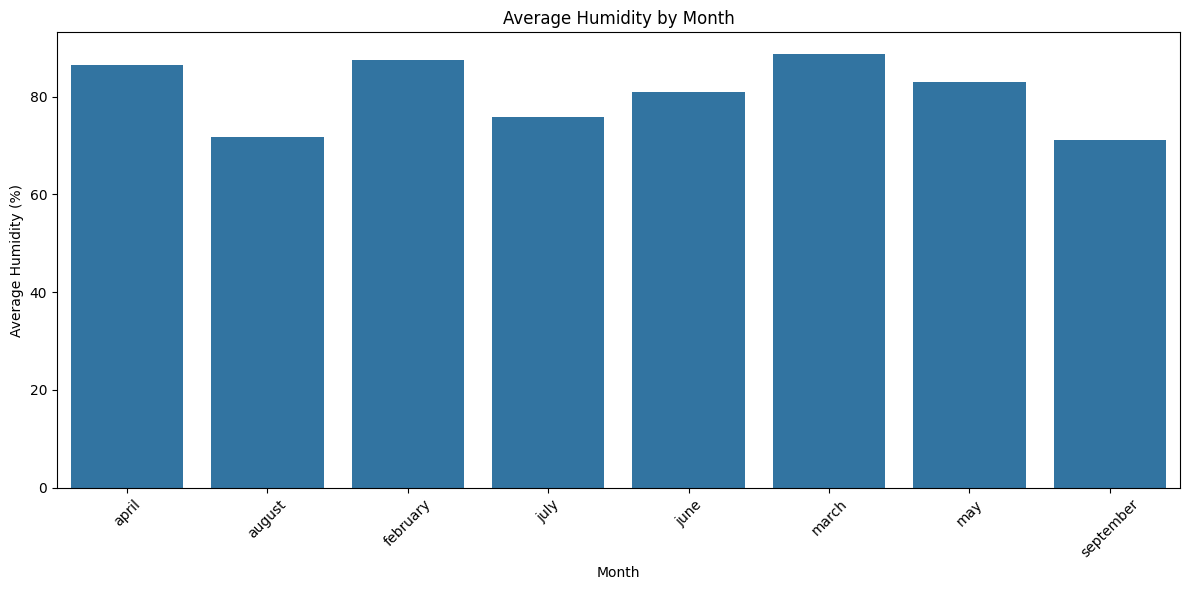


Average Humidity by Month:
April: 86.5%
August: 71.8%
February: 87.4%
July: 75.9%
June: 81.0%
March: 88.7%
May: 82.9%
September: 71.1%

Highest Humidity: 98% on 2024-03-10 at 00:00
Lowest Humidity: 30% on 2024-09-13 at 12:00

Humidity Variability (Standard Deviation) by Month:
April: ±10.1%
August: ±17.0%
February: ±8.9%
July: ±16.1%
June: ±14.1%
March: ±8.9%
May: ±12.6%
September: ±18.0%


In [31]:


weather_df['humidity'] = pd.to_numeric(weather_df['humidity'], errors='coerce')

# Calculate average humidity by month
monthly_avg_humidity = weather_df.groupby('month')['humidity'].mean().round(1)

# Create a bar plot of average humidity by month
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg_humidity.index, y=monthly_avg_humidity.values)
plt.title('Average Humidity by Month')
plt.xlabel('Month')
plt.ylabel('Average Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the numeric values
print("\nAverage Humidity by Month:")
for month, humidity in monthly_avg_humidity.items():
    print(f"{month.capitalize()}: {humidity}%")

# Find days with highest and lowest humidity
highest_humidity = weather_df.loc[weather_df['humidity'].idxmax()]
lowest_humidity = weather_df.loc[weather_df['humidity'].idxmin()]

print(f"\nHighest Humidity: {highest_humidity['humidity']}% on {highest_humidity['date']} at {highest_humidity['time']}")
print(f"Lowest Humidity: {lowest_humidity['humidity']}% on {lowest_humidity['date']} at {lowest_humidity['time']}")

# Calculate humidity variability
humidity_std = weather_df.groupby('month')['humidity'].std().round(1)
print("\nHumidity Variability (Standard Deviation) by Month:")
for month, std in humidity_std.items():
    print(f"{month.capitalize()}: ±{std}%")


In [33]:
# 1. Convert all numeric columns to proper data types
numeric_columns = ['temperature', 'feels_like', 'precip_mm', 'humidity', 
                  'visibility', 'pressure', 'cloud_cover', 'wind_speed']

for col in numeric_columns:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')

# 2. Convert date and time to datetime
weather_df['datetime'] = pd.to_datetime(weather_df['date'] + ' ' + weather_df['time'])
weather_df['hour'] = weather_df['datetime'].dt.hour
weather_df['day'] = weather_df['datetime'].dt.day
weather_df['month_num'] = weather_df['datetime'].dt.month

In [36]:
# 3. Create cyclical features for time-based variables
def create_cyclical_features(df, col, period):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    return df

weather_df = create_cyclical_features(weather_df, 'hour', 24)
weather_df = create_cyclical_features(weather_df, 'month_num', 12)

# 4. Calculate rolling statistics (last 24 hours)
window = 24
weather_df['temp_rolling_mean'] = weather_df.groupby('month')['temperature'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean())
weather_df['temp_rolling_std'] = weather_df.groupby('month')['temperature'].transform(
    lambda x: x.rolling(window=window, min_periods=1).std())

# 5. Calculate lag features
weather_df['temp_lag_24'] = weather_df.groupby('month')['temperature'].shift(24)
weather_df['humidity_lag_24'] = weather_df.groupby('month')['humidity'].shift(24)


In [37]:
weather_df

,date,time,temperature,feels_like,precip_mm,humidity,visibility,pressure,cloud_cover,wind_speed,...,day,month_num,hour_sin,hour_cos,month_num_sin,month_num_cos,temp_rolling_mean,temp_rolling_std,temp_lag_24,humidity_lag_24
0,2024-02-01,00:00,18,18,0.2,92,9,1014,76,4,...,1,2,0.000000e+00,1.000000e+00,0.866025,5.000000e-01,18.000000,NaN,NaN,NaN
1,2024-02-01,03:00,18,18,0.0,92,10,1013,27,5,...,1,2,7.071068e-01,7.071068e-01,0.866025,5.000000e-01,18.000000,0.000000,NaN,NaN
2,2024-02-01,06:00,18,18,0.0,90,10,1014,40,3,...,1,2,1.000000e+00,6.123234e-17,0.866025,5.000000e-01,18.000000,0.000000,NaN,NaN
3,2024-02-01,09:00,27,29,0.2,71,9,1014,74,2,...,1,2,7.071068e-01,-7.071068e-01,0.866025,5.000000e-01,20.250000,4.500000,NaN,NaN
4,2024-02-01,12:00,28,32,1.0,75,10,1012,59,3,...,1,2,1.224647e-16,-1.000000e+00,0.866025,5.000000e-01,21.800000,5.215362,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,2024-09-30,09:00,31,33,0.0,49,10,1012,4,1,...,30,9,7.071068e-01,-7.071068e-01,-1.000000,-1.836970e-16,25.000000,4.491538,30.0,57.0
1940,2024-09-30,12:00,33,35,0.0,41,10,1009,86,7,...,30,9,1.224647e-16,-1.000000e+00,-1.000000,-1.836970e-16,25.083333,4.624290,31.0,55.0
1941,2024-09-30,15:00,31,33,0.0,54,10,1008,84,8,...,30,9,-7.071068e-01,-7.071068e-01,-1.000000,-1.836970e-16,25.291667,4.777476,26.0,80.0
1942,2024-09-30,18:00,25,27,0.0,86,10,1011,75,3,...,30,9,-1.000000e+00,-1.836970e-16,-1.000000,-1.836970e-16,25.333333,4.770076,24.0,90.0



=== Temperature Analysis ===

Monthly Statistics:
            mean   std  min  max
month                           
april      23.02  4.47   16   31
august     24.00  4.34   17   33
february   23.19  3.93   17   30
july       23.76  3.60   18   31
june       24.26  3.13   18   32
march      23.16  3.85   18   31
may        24.30  3.53   16   31
september  24.60  4.65   18   33

Top Correlations with temperature:
temperature    1.000000
feels_like     0.973645
cloud_cover    0.241782
precip_mm      0.133088
visibility     0.112338
wind_speed    -0.201988
pressure      -0.339568
humidity      -0.763853
Name: temperature, dtype: float64


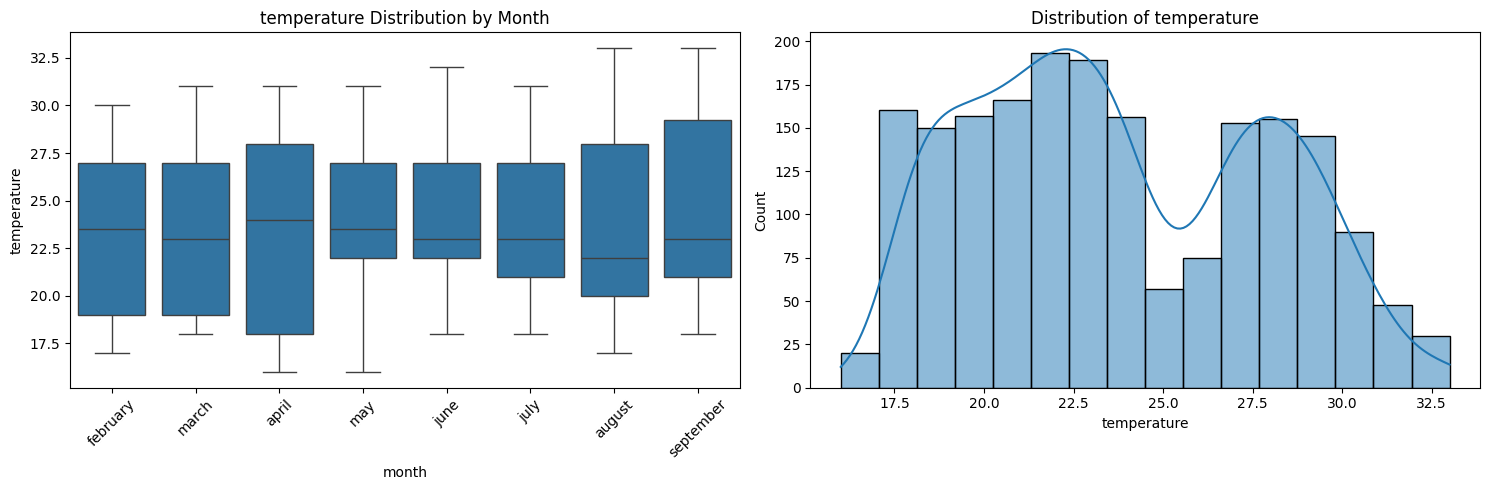


=== Humidity Analysis ===

Monthly Statistics:
            mean    std  min  max
month                            
april      86.53  10.07   57   96
august     71.81  17.01   33   95
february   87.37   8.95   64   97
july       75.91  16.12   41   97
june       81.03  14.07   37   95
march      88.67   8.93   60   98
may        82.92  12.64   49   95
september  71.07  17.96   30   93

Top Correlations with humidity:
humidity       1.000000
cloud_cover    0.159818
pressure       0.158149
precip_mm      0.143435
wind_speed     0.073771
visibility    -0.200914
feels_like    -0.639757
temperature   -0.763853
Name: humidity, dtype: float64


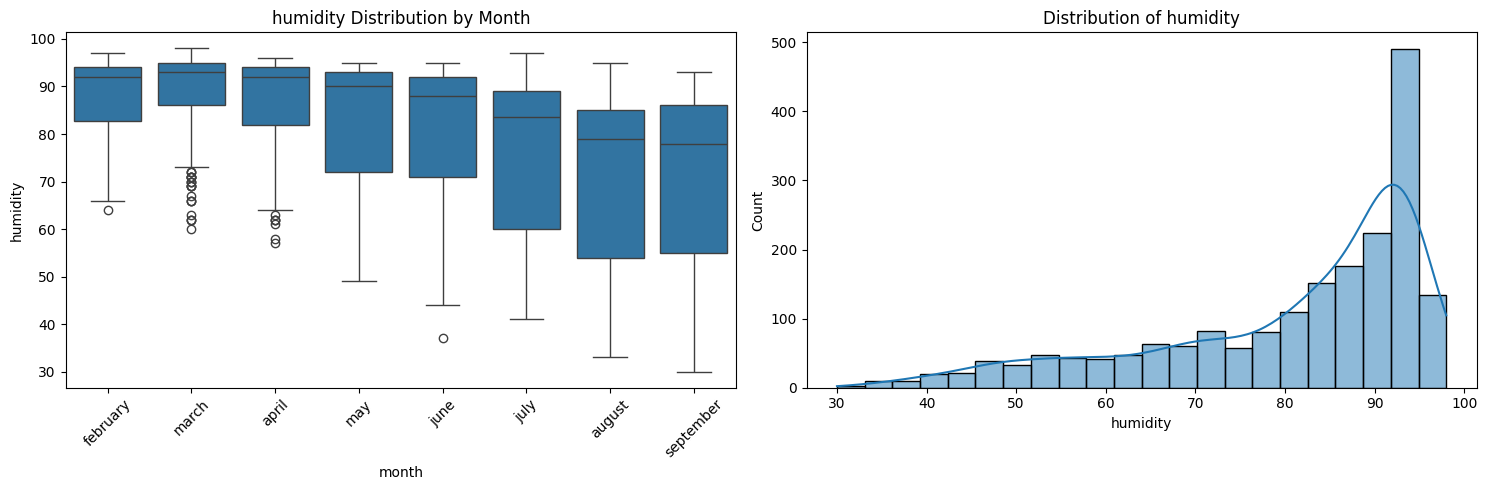


=== Precip Mm Analysis ===

Monthly Statistics:
           mean   std  min  max
month                          
april      0.46  1.07  0.0  9.8
august     0.03  0.13  0.0  1.2
february   0.68  1.28  0.0  9.3
july       0.09  0.53  0.0  6.3
june       0.13  0.37  0.0  2.9
march      0.58  0.83  0.0  6.3
may        0.13  0.28  0.0  2.3
september  0.10  0.39  0.0  4.6

Top Correlations with precip_mm:
precip_mm      1.000000
cloud_cover    0.311514
feels_like     0.198771
humidity       0.143435
temperature    0.133088
wind_speed    -0.077657
visibility    -0.164678
pressure      -0.263999
Name: precip_mm, dtype: float64


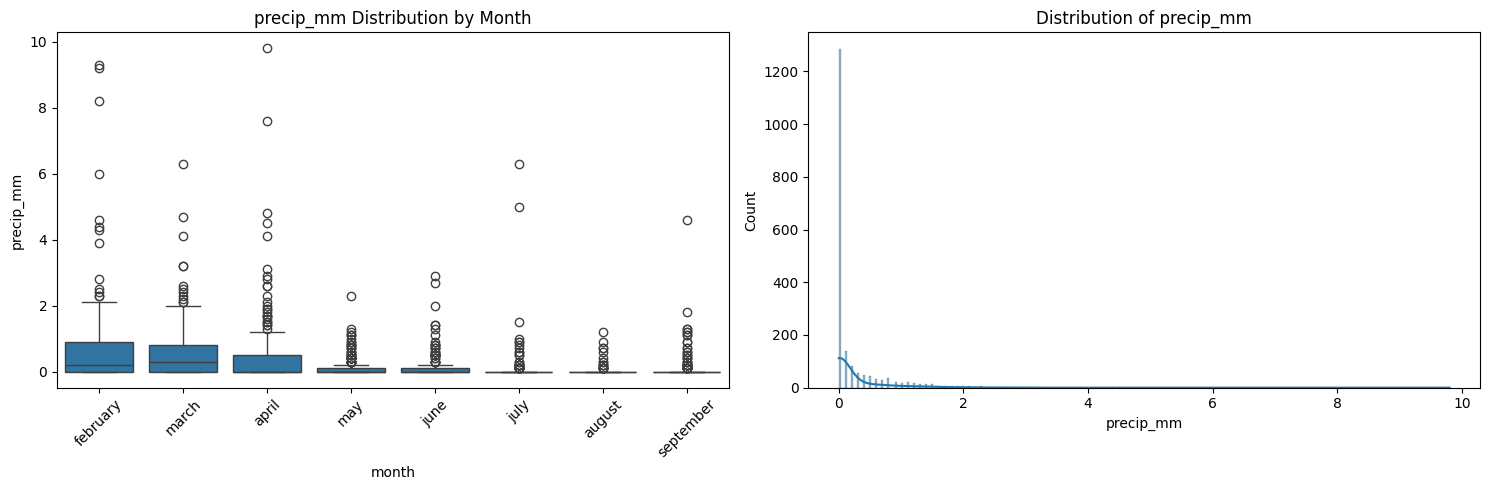


=== Wind Speed Analysis ===

Monthly Statistics:
           mean   std  min  max
month                          
april      2.99  1.75    0   10
august     4.54  2.08    0   10
february   3.04  1.73    0    8
july       4.42  1.80    0    8
june       3.74  1.86    0    9
march      3.50  2.22    0   10
may        3.65  1.69    0   10
september  4.16  1.99    0   10

Top Correlations with wind_speed:
wind_speed     1.000000
pressure       0.145323
humidity       0.073771
visibility     0.057238
precip_mm     -0.077657
cloud_cover   -0.181940
temperature   -0.201988
feels_like    -0.207067
Name: wind_speed, dtype: float64


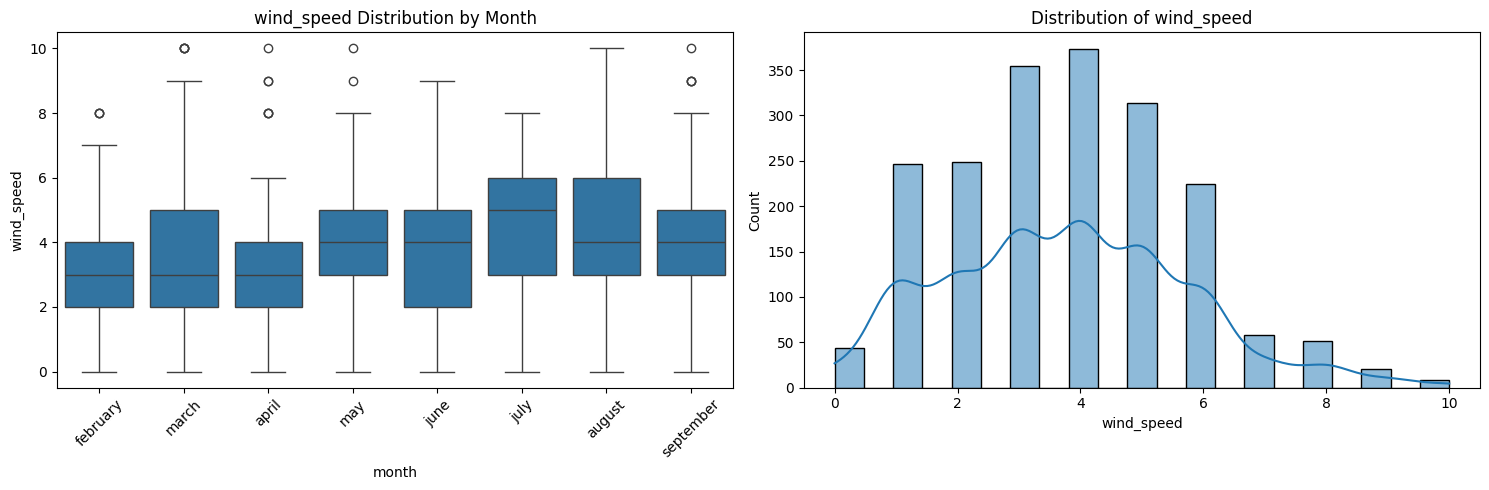

In [38]:
# 6. Basic statistical analysis
def analyze_weather_variable(df, variable):
    print(f"\n=== {variable.replace('_', ' ').title()} Analysis ===")
    
    # Monthly statistics
    monthly_stats = df.groupby('month')[variable].agg(['mean', 'std', 'min', 'max']).round(2)
    print("\nMonthly Statistics:")
    print(monthly_stats)
    
    # Correlation with other variables
    correlations = df[numeric_columns].corr()[variable].sort_values(ascending=False)
    print(f"\nTop Correlations with {variable}:")
    print(correlations)
    
    # Visualize distribution
    plt.figure(figsize=(15, 5))
    
    # Monthly boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='month', y=variable)
    plt.title(f'{variable} Distribution by Month')
    plt.xticks(rotation=45)
    
    # Overall distribution
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=variable, kde=True)
    plt.title(f'Distribution of {variable}')
    
    plt.tight_layout()
    plt.show()

# Analyze key variables
for var in ['temperature', 'humidity', 'precip_mm', 'wind_speed']:
    analyze_weather_variable(weather_df, var)

In [39]:
# 7. Check for missing values and outliers
def check_data_quality(df):
    print("\n=== Data Quality Report ===")
    
    # Missing values
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(missing[missing > 0])
    
    # Outliers (using IQR method)
    outliers = {}
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = len(df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))])
    
    print("\nNumber of Outliers:")
    for col, count in outliers.items():
        print(f"{col}: {count}")

check_data_quality(weather_df)


=== Data Quality Report ===

Missing Values:
temp_rolling_std      8
temp_lag_24         192
humidity_lag_24     192
dtype: int64

Number of Outliers:
temperature: 0
feels_like: 0
precip_mm: 293
humidity: 36
visibility: 316
pressure: 0
cloud_cover: 0
wind_speed: 9


In [41]:
# 1. Handle missing values
def handle_missing_values(df):
    # For rolling statistics, forward fill within groups
    df['temp_rolling_std'] = df.groupby('month')['temp_rolling_std'].fillna(method='ffill')
    
    # For lag features, we can either:
    # Option 1: Fill with rolling means
    df['temp_lag_24'] = df['temp_lag_24'].fillna(df['temp_rolling_mean'])
    df['humidity_lag_24'] = df['humidity_lag_24'].fillna(df.groupby('month')['humidity'].transform('mean'))
    
    return df

# 2. Handle outliers
def handle_outliers(df):
    # For precipitation: Keep as is (rainfall spikes are natural)
    
    # For visibility: Cap at percentiles
    lower_visibility = df['visibility'].quantile(0.05)
    upper_visibility = df['visibility'].quantile(0.95)
    df['visibility_cleaned'] = df['visibility'].clip(lower_visibility, upper_visibility)
    
    # For humidity: Cap at physical limits
    df['humidity_cleaned'] = df['humidity'].clip(0, 100)
    
    # For wind speed: Cap at percentiles
    lower_wind = df['wind_speed'].quantile(0.05)
    upper_wind = df['wind_speed'].quantile(0.95)
    df['wind_speed_cleaned'] = df['wind_speed'].clip(lower_wind, upper_wind)
    
    return df

# Apply the functions
weather_df = handle_missing_values(weather_df)
weather_df = handle_outliers(weather_df)

C:\Users\USER\AppData\Local\Temp\ipykernel_3472\366148997.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['temp_rolling_std'] = df.groupby('month')['temp_rolling_std'].fillna(method='ffill')
C:\Users\USER\AppData\Local\Temp\ipykernel_3472\366148997.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['temp_rolling_std'] = df.groupby('month')['temp_rolling_std'].fillna(method='ffill')


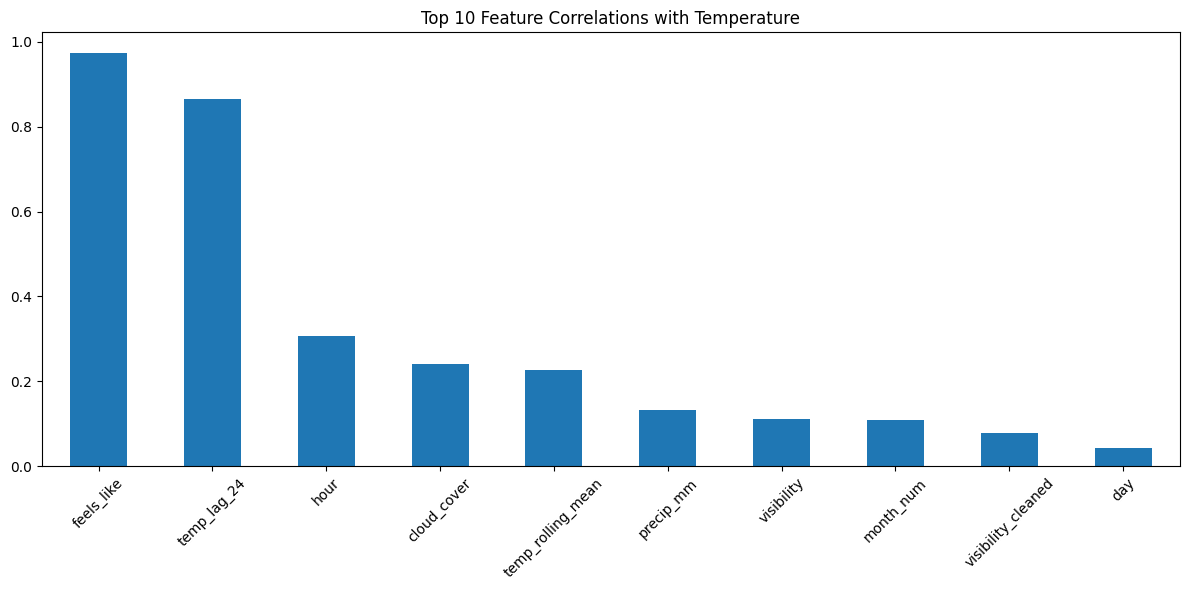

In [42]:
# 3. Create feature importance analysis
def analyze_feature_importance(df):
    # Example: Correlation with temperature
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()['temperature'].sort_values(ascending=False)
    
    # Visualize correlations
    plt.figure(figsize=(12, 6))
    correlations[1:11].plot(kind='bar')  # Top 10 correlations excluding temperature itself
    plt.title('Top 10 Feature Correlations with Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return correlations

correlations = analyze_feature_importance(weather_df)


In [44]:
# 4. Create additional weather-specific features
def create_weather_features(df):
    # Temperature variation
    df['temp_range'] = df.groupby('date')['temperature'].transform(lambda x: x.max() - x.min())
    
    # Dew point calculation (Magnus formula)
    df['dew_point'] = df.apply(lambda row: (row['temperature'] - ((100 - row['humidity']) / 5)), axis=1)
    
    # Heat index (simplified version)
    df['heat_index'] = df.apply(
        lambda row: row['temperature'] + (0.55 * (1 - np.exp(-0.0216 * row['humidity']))), 
        axis=1
    )
    
    # Weather change indicators
    df['temp_change'] = df.groupby('date')['temperature'].diff()
    df['pressure_change'] = df.groupby('date')['pressure'].diff()
    
    return df

weather_df = create_weather_features(weather_df)

## 1. Dew Point

**Definition:** The temperature at which water vapor in the air begins to condense

**Importance:**
- Indicates humidity comfort level
- Good predictor of fog and precipitation  
- Key factor in human comfort

**Interpretation:**
| Range | Comfort Level |
|-------|---------------|
| < 10°C | Comfortable |
| 10-15°C | Getting humid |
| 16-18°C | Uncomfortable |
| > 18°C | Very uncomfortable |

## Heat Index

**Definition:** How hot it actually feels when humidity is combined with temperature

**Importance:**
- Better indicator of human comfort than temperature alone
- Critical for health and safety warnings

**Interpretation:**
| Range | Risk Level |
|-------|------------|
| < 27°C | Safe |
| 27-32°C | Caution |
| 32-41°C | Extreme caution |
| 41-54°C | Danger |
| > 54°C | Extreme danger |



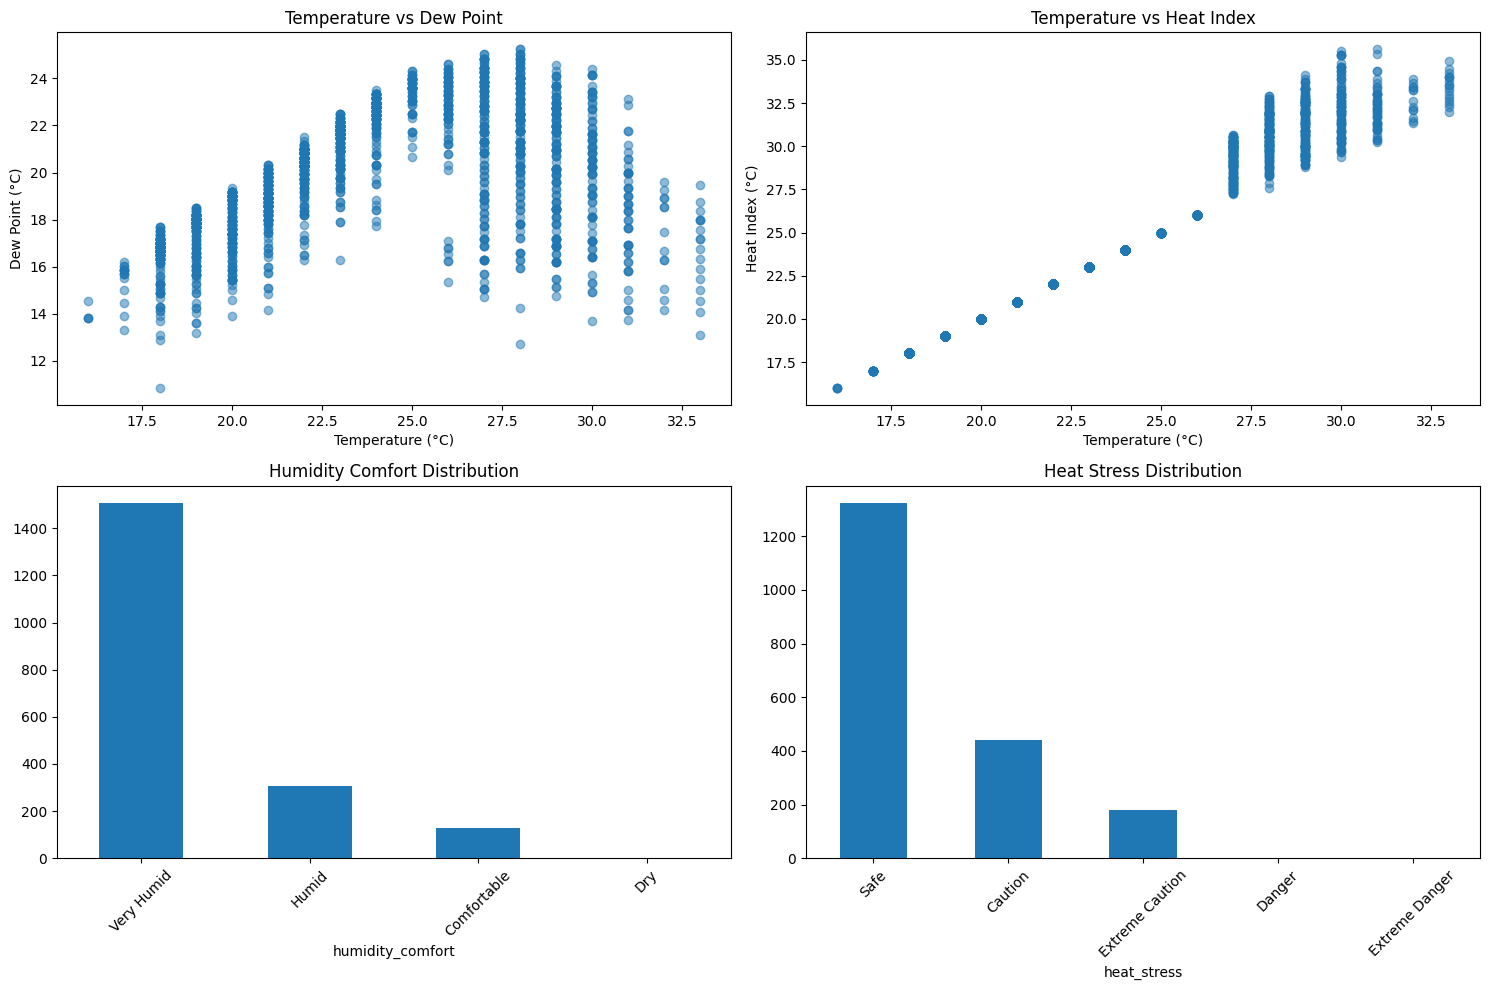


Dew Point Summary:
count    1944.000000
mean       19.865212
std         2.664224
min        10.846923
25%        17.766634
50%        20.025778
75%        22.066560
max        25.234198
Name: dew_point, dtype: float64

Heat Index Summary:
count    1944.000000
mean       24.482227
std         4.909136
min        16.000000
25%        20.000000
50%        23.000000
75%        29.539999
max        35.616501
Name: heat_index, dtype: float64


In [46]:
def create_weather_features(df):
    """
    Create advanced weather features including dew point and heat index
    """
    
    # 1. Dew Point Calculation (Magnus-Tetens formula)
    def calculate_dew_point(T, RH):
        """
        Calculate dew point using Magnus-Tetens formula
        T: Temperature in Celsius
        RH: Relative Humidity (0-100)
        Returns: Dew point in Celsius
        """
        a = 17.27
        b = 237.7
        
        # Calculate alpha
        alpha = ((a * T) / (b + T)) + np.log(RH/100.0)
        
        # Calculate dew point
        dew_point = (b * alpha) / (a - alpha)
        return dew_point
    
    # 2. Heat Index Calculation (Rothfusz regression)
    def calculate_heat_index(T, RH):
        """
        Calculate heat index using Rothfusz regression
        T: Temperature in Celsius
        RH: Relative Humidity (0-100)
        Returns: Heat index in Celsius
        """
        # Convert Celsius to Fahrenheit for the formula
        T_F = (T * 9/5) + 32
        
        # Simple formula if temperature is less than 80°F
        if T_F < 80:
            return T
        
        # Rothfusz regression
        hi = -42.379 + (2.04901523 * T_F) + (10.14333127 * RH) \
             - (0.22475541 * T_F * RH) - (6.83783e-3 * T_F**2) \
             - (5.481717e-2 * RH**2) + (1.22874e-3 * T_F**2 * RH) \
             + (8.5282e-4 * T_F * RH**2) - (1.99e-6 * T_F**2 * RH**2)
        
        # Convert back to Celsius
        hi_C = (hi - 32) * 5/9
        return hi_C
    
    # Apply calculations
    df['dew_point'] = df.apply(lambda row: calculate_dew_point(
        row['temperature'], 
        row['humidity']
    ), axis=1)
    
    df['heat_index'] = df.apply(lambda row: calculate_heat_index(
        row['temperature'], 
        row['humidity']
    ), axis=1)
    
    # Add comfort indicators
    df['humidity_comfort'] = pd.cut(
        df['humidity'],
        bins=[0, 30, 50, 70, 100],
        labels=['Dry', 'Comfortable', 'Humid', 'Very Humid']
    )
    
    df['heat_stress'] = pd.cut(
        df['heat_index'],
        bins=[-np.inf, 27, 32, 41, 54, np.inf],
        labels=['Safe', 'Caution', 'Extreme Caution', 'Danger', 'Extreme Danger']
    )
    
    return df

# Apply the features
weather_df = create_weather_features(weather_df)

# Analyze the new features
def analyze_comfort_metrics(df):
    """
    Analyze and visualize comfort metrics
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Dew Point vs Temperature
    plt.subplot(2, 2, 1)
    plt.scatter(df['temperature'], df['dew_point'], alpha=0.5)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Dew Point (°C)')
    plt.title('Temperature vs Dew Point')
    
    # Plot 2: Heat Index vs Temperature
    plt.subplot(2, 2, 2)
    plt.scatter(df['temperature'], df['heat_index'], alpha=0.5)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Heat Index (°C)')
    plt.title('Temperature vs Heat Index')
    
    # Plot 3: Humidity Comfort Distribution
    plt.subplot(2, 2, 3)
    df['humidity_comfort'].value_counts().plot(kind='bar')
    plt.title('Humidity Comfort Distribution')
    plt.xticks(rotation=45)
    
    # Plot 4: Heat Stress Distribution
    plt.subplot(2, 2, 4)
    df['heat_stress'].value_counts().plot(kind='bar')
    plt.title('Heat Stress Distribution')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDew Point Summary:")
    print(df['dew_point'].describe())
    
    print("\nHeat Index Summary:")
    print(df['heat_index'].describe())

# Run the analysis
analyze_comfort_metrics(weather_df)

In [53]:
# Remove unwanted categories and data
weather_df = weather_df[~weather_df['humidity_comfort'].isin(['Dry'])]
weather_df = weather_df[~weather_df['heat_stress'].isin(['Danger', 'Extreme Danger'])]

# Remove unused categories
weather_df['humidity_comfort'] = weather_df['humidity_comfort'].cat.remove_unused_categories()
weather_df['heat_stress'] = weather_df['heat_stress'].cat.remove_unused_categories()

# Print updated value counts to verify changes
print("\nUpdated Humidity Comfort Distribution:")
print(weather_df['humidity_comfort'].value_counts())
print("\nCategories:", weather_df['humidity_comfort'].cat.categories.tolist())

print("\nUpdated Heat Stress Distribution:") 
print(weather_df['heat_stress'].value_counts())
print("\nCategories:", weather_df['heat_stress'].cat.categories.tolist())


Updated Humidity Comfort Distribution:
humidity_comfort
Very Humid     1506
Humid           308
Comfortable     129
Name: count, dtype: int64

Categories: ['Comfortable', 'Humid', 'Very Humid']

Updated Heat Stress Distribution:
heat_stress
Safe               1323
Caution             440
Extreme Caution     180
Name: count, dtype: int64

Categories: ['Safe', 'Caution', 'Extreme Caution']


In [54]:
weather_df['humidity_comfort'].unique()

['Very Humid', 'Humid', 'Comfortable']
Categories (3, object): ['Comfortable' < 'Humid' < 'Very Humid']

In [ ]:
# 8. Save processed dataset
processed_weather_df = weather_df.copy()

# Select relevant features for your specific use case
feature_columns = [
    'datetime', 'temperature', 'feels_like', 'precip_mm', 'humidity', 'heat_index', 'dew_point'
    'visibility', 'pressure', 'cloud_cover', 'wind_speed',
    'temp_rolling_mean', 'temp_rolling_std',
    'temp_lag_24', 'humidity_lag_24', 'heat_stress', 'humidity_comfort'
]

processed_weather_df = processed_weather_df[feature_columns]

# Save to CSV
processed_path = os.path.join('..', 'data', 'processed')
processed_weather_df.to_csv(os.path.join(processed_path, 'processed_weather_features.csv'), index=False)